## PCA  -  Monthly Climatology dataset

In [2]:
from netCDF4 import Dataset
import numpy as np
from sklearn.preprocessing import normalize
import dask.array as da
from dask_ml.decomposition import PCA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
dataset = Dataset('./LIS_VHRES/data_climatology/VHRMC.nc', 'r').variables['VHRMC_LIS_FRD'][:]
frd = dataset.data
frd.shape

(12, 760, 3600)

In [4]:
#create a mask and appply it on the data (see Data Acquisition & Preprocess)
mask = np.asarray([np.sum(frd,0)==0])
mask = mask.reshape(760, 3600)
masks = np.asarray([mask]*frd.shape[0])

frd_masked = np.ma.masked_where(masks==True, frd)
frd_masked[masks==True] = np.nan

frd_reshaped = frd_masked.reshape(frd_masked.shape[0], frd_masked.shape[1]*frd_masked.shape[2])

#mask out the unimportant areas
mask2 = np.isnan(frd_reshaped[0, :])
frd_clean = frd_reshaped[:, ~mask2]

In [5]:
#normalize the data
frd_norm = normalize(frd_clean)
#put data in dask chunks
frd_da = da.from_array(frd_norm, chunks=(frd_norm.shape[0], frd_norm.shape[1]))

In [6]:
#PCA with 3 components
n_components = 3

pca = PCA(n_components, whiten=True)
pca.fit(frd_da)

print('The explained variance ratio is {} \n'.format(pca.explained_variance_ratio_))
print('The PCA describes the {}% of the data'.format(round(np.nansum(pca.explained_variance_ratio_)*100)))

pca_data = pca.components_.reshape((n_components*frd_da.shape[1]))

The explained variance ratio is [0.63044442 0.17422906 0.09685796] 

The PCA describes the 90.0% of the data


In [7]:
#put everything back together and mask out the unimportant areas
frd_pca = np.ones(n_components*760*3600)
frd_pca.fill(np.nan)
mask3 = np.asarray([mask]*n_components) 
frd_pca[~mask3.ravel()]= pca_data
frd_pca = frd_pca.reshape(n_components, 760, 3600)

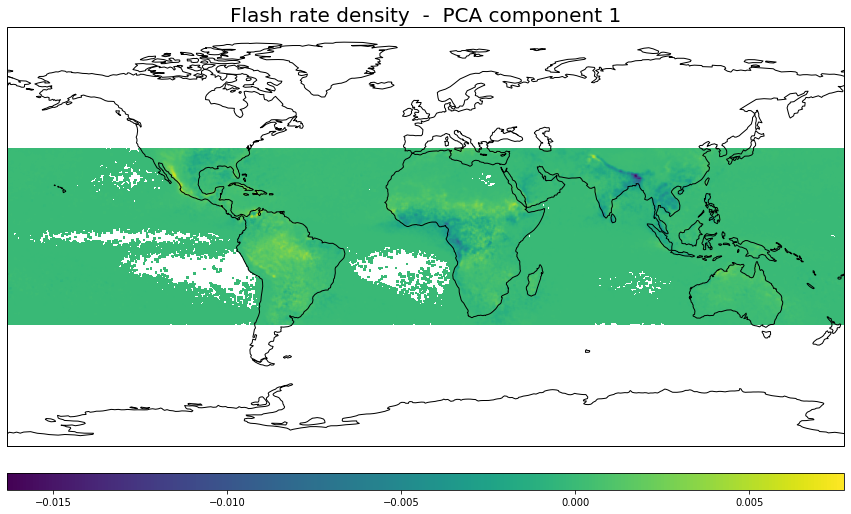

In [9]:
plt.close('all')
plt.figure(figsize=((15,10))) 

#plot the map
img = plt.axes(projection=ccrs.PlateCarree())
img.set_extent([-180, 180, -90, 90])
img.coastlines()

#PCA results for the first component
pca_1 = img.imshow(frd_pca[1,:,:], extent = [-180, 180, -38, 38])
cb = plt.colorbar(pca_1, orientation='horizontal', pad=0.05, aspect = 50) 

plt.title('Flash rate density  -  PCA component 1', loc = 'center', fontsize = 20)

plt.savefig('PCA_Monthly Climatology.png')

plt.show()